## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import os
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Set your working directory (in your google drive) 
#   change it to your specific homework directory.
%cd '/content/gdrive/MyDrive/Meng_Alex_114477057_hw5'

/content/gdrive/MyDrive/Meng_Alex_114477057_hw5


In [ ]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # Write your code here
  # normalize img pixels to [-1, 1]
  result = cv2.normalize(img, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  return result

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                rotate_90=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))
            
    #
    # Write your Data Augmentation code here
    # mirroring
    #
    if augment:
      print("Data Augmentation by mirroring!")
      mirrored_img = []
      mirrored_lab = []
      for index, img in enumerate(data):
        mirrored = cv2.flip(img, 1)
        mirrored_img.append(mirrored)
        mirrored_lab.append(labels[index])
    
      data.extend(mirrored_img)
      labels.extend(mirrored_lab)

    #
    # Rotation by 90 degrees
    #
    if rotate_90:
      print("Rotation by 90 degreed counter-clockwise!")
      mirrored_img = []
      mirrored_lab = []
      for index, img in enumerate(data):
        rows, cols = img.shape
        Rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
        rotated_img = cv2.warpAffine(img, Rot_M, (cols, rows))
        mirrored_img.append(rotated_img)
        mirrored_lab.append(labels[index])
      
      data.extend(mirrored_img)
      labels.extend(mirrored_lab)

    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    #
    if zero_centered:
      mean = np.mean(data, axis=0)
      for index, img in enumerate(data):
        data[index] = img - mean
     
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'OpenCountry', 1: 'LivingRoom', 2: 'Bedroom', 3: 'Office', 4: 'InsideCity', 5: 'Suburb', 6: 'Industrial', 7: 'Kitchen', 8: 'Mountain', 9: 'Street', 10: 'Store', 11: 'TallBuilding', 12: 'Coast', 13: 'Forest', 14: 'Flower', 15: 'Highway'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Data Augmentation by mirroring!
4800
50
Finish loading 96 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from clas

Industrial


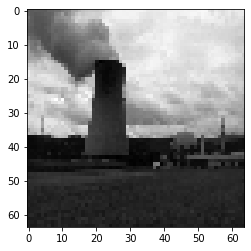

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

# Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) **you should be able to achieve around 50% test accuracy**. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [ ]:
# ==========================================
#       Define Network Architecture
# ==========================================
class ClassifierNetwork(nn.Module):

    def __init__(self, num_classes, d_out):
        super(ClassifierNetwork, self).__init__()
        # Convolution
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.d_out = nn.Dropout(d_out)
        self.conv3 = nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully Connected Layers
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool1(y)
        y = self.d_out(y)
        y = self.conv3(y)
        y = self.relu3(y)
        y = self.pool2(y)
        y = y.view(y.size(0), -1)
        y = self.fc1(y)
        y = self.fc2(y)
        y = self.fc3(y)
        return y

In [ ]:
# ==========================================
#         Optimize/Train Network
# ==========================================
def train(num_epochs, learning_rate, model, training_images, optimizer=None):
  # Uses the Adam optimizer
  if optimizer == None:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  # Cross-entropy loss function
  criterion = nn.CrossEntropyLoss()
  since = time.time()
  # If GPU is used
  if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

  model.train()
  print(model)
  total_step = len(training_images)
  print(total_step)
  loss_list = []
  acc_list = []
  # for every epoch
  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(training_images):
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      # Forward propogation
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss_list.append(loss.item())
      # Backward propagation
      optimizer.zero_grad()
      loss.backward()
      # Perform Adam optimization
      optimizer.step()
      # Keep track of accuracy
      total = labels.size(0)
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted == labels).sum().item()
      acc_list.append(correct / total)
      # Print stats
      if i % (total_step - 1) == 0 and i != 0:
        print('Epoch ({}/{}), Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, loss.item(),
                    (correct / total) * 100))
            
  elapsed = time.time() - since
  print('Train time elapsed: ', elapsed, 'seconds')


learning_rate = 0.001
num_epochs = 20
d_out = 0.5
num_classes = 16
model = ClassifierNetwork(num_classes, d_out)
train(num_epochs, learning_rate, model, trainloader_small)

ClassifierNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d_out): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)
96
Epoch (1/20), Loss: 2.3533, Accuracy: 32.00%
Epoch (2/20), Loss: 1.7442, Accuracy: 44.00%
Epoch (3/20), Loss: 1.3741, Accuracy: 54.00%
Epoch (4/20), Loss: 1.1344, Accuracy: 74.00%
Epoch (5/20), Loss: 1.0017, Accuracy: 68.00%
Epoch (6/20), Loss: 0.8697, Accuracy: 76.00%
Epoch (7/20), Loss: 0.7255,

In [ ]:
# ==========================================
#            Evaluating Network
# ==========================================
def test(model, test_images):
  since = time.time()
  model.eval()
  with torch.no_grad():
      c, t = 0, 0
      for images, labels in test_images:
          # Use GPU if it is avaiable
          if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          t += labels.size(0)
          c += (predicted == labels).sum().item()
      print('Test Accuracy on test images: {} %'.format((c / t) * 100))
  elapsed = time.time() - since
  print('Test time elapsed: ', elapsed, 'seconds')

#evaluate
test(model, testloader_small)

Test Accuracy on test images: 55.25 %
Test time elapsed:  0.042157649993896484 seconds


## [***Report on Network Layout***]

# **Data Pre-processing** 

**Data Augmentation**: 

To generate 2400 more images to add to the existing amount of training images, I performed data augmentation where each training image (not testing images) was horizontally mirrored/flipped.

**Data Normalization**: 

To normalize the images in both training and testing datasets, I subtracted the mean of all images from each image to zero-center each image. 

# **CNN Architecture:**

Layer 1: Convolution 1 (conv1): 1 input, 32 output, 3x3 kernel, 1px stride, 1ps padding

Layer 2: ReLU 1 (relu1)

Layer 3: Convolution 1 (conv1): 32 input, 64 output, 3x3 kernel, 1px stride, 1ps padding

Layer 4: RelU 2(relu2)

Layer 5: Max Pooling 1 (pool1): 2x2 kernel, 2px stride, 0px padding

Layer 6: Dropout (d_out): 0.5 dropout rate

Layer 7: Convolution 3 (conv3): 64 input, 16 output, 3x3 kernels, 1px stride, 1px padding

Layer 8: ReLU 3 (relu3)

Layer 9: Max Pooling 2 (pool2): 2x2 kernel, 2px stride, 0px padding

**Fully connected Layers**

1. fc1: in=4096, out=64, bias=True
2. fc2: in=64, out=32, bias=True
3. fc3: in=32, out=16, bias=True

**Hyperparameters**

1. Optimizer: Adam
2. Loss Function: Cross-Entropy
3. Number of Epochs: 30
4. Learning Rate: 0.001

**Overall Performance**

Total Training time: ~34 seconds

Test time: ~0.05 seconds

Accuracy of Model: ~55%




## Part2
List each of the techniques you used and the performances after using these techniques
<br> Please clearly indicate the techniques you use in the text blocks

## Technique 1: Batch normalization

To ensure that intermediate layers do not depend too much on preceding layers, we can perform batch normalizaition where I added batch normalization layers after 2nd, 3rd, and 2nd fully connected layers.

In [ ]:
# ==========================================
#       Technique1: Batch normalization
# ==========================================
class ClassifierNetworkBatchNorm(nn.Module):

    def __init__(self, num_classes, d_out):
      super(ClassifierNetworkBatchNorm, self).__init__()
      # Convolution
      self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
      self.relu1 = nn.ReLU()
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
      self.conv2_bn = nn.BatchNorm2d(64) ##
      self.relu2 = nn.ReLU()
      self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      self.d_out = nn.Dropout(d_out)
      self.conv3 = nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1)
      self.conv3_bn = nn.BatchNorm2d(16) ##
      self.relu3 = nn.ReLU()
      self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      # Fully Connected Layers
      self.fc1 = nn.Linear(16 * 16 * 16, 64)
      self.fc2 = nn.Linear(64, 32)
      self.fc2_bn = nn.BatchNorm1d(32) ###
      self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
      y = self.conv1(x)
      y = self.relu1(y)
      y = self.conv2(y)
      y = self.conv2_bn(y)
      y = self.relu2(y)
      y = self.pool1(y)
      y = self.d_out(y)
      y = self.conv3(y)
      y = self.conv3_bn(y)
      y = self.relu3(y)
      y = self.pool2(y)
      y = y.view(y.size(0), -1)
      y = self.fc1(y)
      y = self.fc2(y)
      y = self.fc2_bn(y)
      y = self.fc3(y)
      return y

bn_model = ClassifierNetworkBatchNorm(num_classes, d_out)
train(10, learning_rate, bn_model, trainloader_small)
test(bn_model, testloader_small)


ClassifierNetworkBatchNorm(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d_out): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc2_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)
96
Epoch (1

***Performance evaluation for techinque 1***

Training time: ~20 seconds

Testing time: ~0.05 seconds

Accuracy: ~ 57%


Because the accuracy reach about 100% at the 10th epoch, I lowered the number of epochs to 10. The accuracy increased for about 2% with this technique.

## Technique 2: Sigmoid as Activation Function

This techinque tries to use Sigmoid as activation function instead of rectified linear units.

In [ ]:
# ==========================================
#       Technique2: sigmoid
# ==========================================
class ClassifierNetworkSigmoid(nn.Module):

    def __init__(self, num_classes, d_out):
      super(ClassifierNetworkSigmoid, self).__init__()
        
      # Convolution
      self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
      self.sigm1 = nn.Sigmoid()
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
      self.sigm2 = nn.Sigmoid()
      self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      self.d_out = nn.Dropout(d_out)
      self.conv3 = nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1)
      self.sigm3 = nn.Sigmoid()
      self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

      # Fully Connected Layers
      self.fc1 = nn.Linear(16 * 16 * 16, 64)
      self.fc2 = nn.Linear(64, 32)
      self.fc3 = nn.Linear(32, 16)

    def forward(self, x):
      y = self.conv1(x)
      y = self.sigm1(y)
      y = self.conv2(y)
      y = self.sigm2(y)
      y = self.pool1(y)
      y = self.d_out(y)
      y = self.conv3(y)
      y = self.sigm3(y)
      y = self.pool2(y)
      y = y.view(y.size(0), -1)
      y = self.fc1(y)
      y = self.fc2(y)
      y = self.fc3(y)
      return y

sigm_model = ClassifierNetworkSigmoid(num_classes, d_out)
train(30, learning_rate, sigm_model, trainloader_small)

ClassifierNetworkSigmoid(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigm1): Sigmoid()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigm2): Sigmoid()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d_out): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sigm3): Sigmoid()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)
96
Epoch (1/30), Loss: 2.8012, Accuracy: 0.00%
Epoch (2/30), Loss: 2.7919, Accuracy: 0.00%
Epoch (3/30), Loss: 2.7856, Accuracy: 0.00%
Epoch (4/30), Loss: 2.7814, Accuracy: 0.00%
Epoch (5/30), Loss: 2.7787, Accuracy: 0.00%
Epoch (6/30), Loss: 2.7767, Accuracy: 0.00%
Epoch (7/30), Los

In [ ]:
test(sigm_model, testloader_small)

Test Accuracy on test images: 47.75 %
Test time elapsed:  0.04191875457763672 seconds


***Performance evaluation for techinque 2***

Training time: ~52 seconds

Testing time: ~0.05 seconds

Accuracy: ~ 40%


Because the accuracy did not reach about 100% at the 20th epoch, I increased the number of epochs to 30.

## Technique 3: Adding more Augmented Data

if we add more augmented data by rotating the images by 90 degrees counterclockwise, this should increase performance accuracy.

In [ ]:
# ==========================================
#       Technique3: augment data
# ==========================================

img_size = (64, 64)
batch_num = 50

trainloader_small_rot = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, rotate_90=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Data Augmentation by mirroring!
Rotation by 90 degreed counter-clockwise!
9600
50
Finish loading 96 minibatches(=50) of training samples.


In [ ]:
rot_model = ClassifierNetwork(num_classes, d_out)
train(num_epochs, learning_rate, rot_model, trainloader_small_rot)
test(rot_model, testloader_small)

ClassifierNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (d_out): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
)
192
Epoch (1/20), Loss: 2.1334, Accuracy: 28.00%
Epoch (2/20), Loss: 1.6871, Accuracy: 40.00%
Epoch (3/20), Loss: 1.2418, Accuracy: 56.00%
Epoch (4/20), Loss: 1.1382, Accuracy: 62.00%
Epoch (5/20), Loss: 0.9394, Accuracy: 72.00%
Epoch (6/20), Loss: 0.7421, Accuracy: 76.00%
Epoch (7/20), Loss: 0.6459

***Performance evaluation for techinque 3***

Training time: ~64 seconds

Testing time: ~0.05 seconds

Accuracy: ~ 48%


Because the accuracy reach about did not reach 100% at the 20th epoch, the accuracy of the technique should still be improved by increasing the number of epochs.

# Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class:

## Fine tuning Alexnet

I changed the output features of alexnet from 1000 to 16, and that is the only change made to AlexNet.

## Strategy B

In [ ]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, 16)

a_num_epochs = 20
a_learning_rate = 0.0001

train(a_num_epochs, a_learning_rate, alexnet, trainloader_large)
test(alexnet, testloader_large)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

***Result AlexNet architecture***

Layer 1: Convolution 1 (conv1): 3 input, 64 output, 11x11 kernels, 4px stride, 2px padding

Relu 1 (relu1)
Max Pooling 1 (pool1): 3x3 kernel, 2px stride, 0px padding

Layer 2: Convolution 2 (conv2): 64 input, 192 output, 5x5 kernels, 1px stride, 2px padding

Relu 2 (relu2)

Max Pooling 2 (pool2): 3x3 kernel, 2px stride, 0px padding

Layer 3: Convolution 3 (conv3): 192 input, 384 output, 3x3 kernels, 1px stride, 1px padding

Relu 3 (relu3)

Layer 4: Convolution 4 (conv4): 384 input, 256 output, 3x3 kernels, 1px stride, 1px padding

Relu 4 (relu4)

Layer 5: Convolution 5 (conv3): 256 input, 256 output, 3x3 kernels, 1px stride, 1px padding

Relu 5 (relu5)

Max Pooling 3 (pool3): 3x3 kernel, 2px stride, 0px padding

Layer 6: Adaptive Avg Pool (avgpool): output: 6x6

Dropout (d_out): 0.5 dropout rate

fc1: in_features=9216, out_features=4096

Relu 6 (relu6)

Dropout (d_out): 0.5 dropout rate
fc2: in=4096, out=4096

Relu 7 (relu7)

fc3: in=4096, out=16

**Performance Evaluation**

Training time: ~63 seconds

Testing time: ~0.17 seconds

Accuracy: ~86%

## Strategy A

In [ ]:
alexnet_ft = models.alexnet(pretrained=True)
for param in alexnet_ft.parameters():
    param.requires_grad = False

In [ ]:
def extract_features(model, num_features, image_batches):
  model.eval()
  if torch.cuda.is_available():
      model = model.cuda()
  x = []
  y = []
  for i, (images, labels) in enumerate(image_batches):
    if torch.cuda.is_available():
      images, labels = images.cuda(), labels.cuda()
    outputs = model(images)
    for index, output in enumerate(outputs):
      x.append(np.array(output[:num_features].cpu().detach().numpy()))
      y.append(labels[index].cpu().detach().numpy())
  return np.array(x), np.array(y)


num_features = 400
X_train, y_train = extract_features(alexnet_ft, num_features, trainloader_large)
print(len(X_train), len(y_train))

X_test, y_test = extract_features(alexnet_ft, num_features, testloader_large)
print(len(X_test), len(y_test))

2400 2400
400 400


In [ ]:
# Training linear SVC
lin_clf = svm.LinearSVC(C=0.001)

b = time.time()
lin_clf.fit(X_train, y_train)
e = time.time() - b
print('Training time: ', e, 'seconds')

Training time:  0.8662738800048828 seconds


In [ ]:
# Testing on linear SVC
# Using confusion matrix
b = time.time()
y_pred = lin_clf.predict(X_test)
e = time.time() - b
the_confusion_matrix = confusion_matrix(y_test, y_pred)
print('Testing time: ', e, 'seconds')
print('Accuracy is {}%'.format(accuracy_score(y_test, y_pred)*100))
print(the_confusion_matrix)

Testing time:  0.004495859146118164 seconds
Accuracy is 85.25%
[[20  0  0  0  0  0  0  0  0  0  0  0  2  1  0  2]
 [ 0 17  4  0  0  0  0  3  0  0  1  0  0  0  0  0]
 [ 0  5 19  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 22  0  0  1  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  1  2  1  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  1  2  2  0  0  0  0]
 [ 0  4  2  0  0  0  0 18  0  0  1  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 24  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  0  3  0  0 21  0  0  0  0  0]
 [ 0  0  0  0  1  0  2  0  0  0  0 22  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  1  0  0  0 21  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 25  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 25]]


# Bonus: VGG

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, 16)

vgg16_num_epochs = 20
vgg16_learning_rate = 0.0001

train(vgg16_num_epochs, vgg16_learning_rate, vgg16, trainloader_large)
test(vgg16, testloader_large)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

***Performance Evaluation for VGG***

Training time: ~771 seconds

Testing time: ~2.3 seconds

Accuracy: ~92%


Since VGG is a much deeper network than AlexNet, so the training time takes longer but the accuracy inceases. Also VGG uses a 3x3 kernel size but AlexNet uses a 11x11 kernel size, so VGG performs more computations.

As a result, AlexNet did better on training time, where it took around 63 seconds and VGG took around 771 seconds. The accuracy for VGG is better where it has an accuracy of 92%.



<!--Write your report here in markdown or html-->
